# Figure 7

This notebook produces Figure 7 and other auxiliary figures.

## Get data

(1) from the Ice Thickness Models Intercomparison eXperiment (ITMIX) data set (Farinotti et al., 2017), available at https://doi.org/10.5905/ethz-1007-92. Redistributed under the CC BY-NC-SA 4.0 License (see the previous link for details).

Reference: Farinotti, D., Brinkerhoff, D. J., Clarke, G. K. C., Fürst, J. J., Frey, H., Gantayat, P., Gillet-Chaulet, F., Girard, C., Huss, M., Leclercq, P. W., Linsbauer, A., Machguth, H., Martin, C., Maussion, F., Morlighem, M., Mosbeux, C., Pandit, A., Portmann, A., Rabatel, A., …Andreassen, L. M. (2017). How accurate are estimates of glacier ice thickness? Results from ITMIX, the Ice Thickness Models Intercomparison eXperiment. Cryosphere, 11(2), 949–970. https://doi.org/10.5194/tc-11-949-2017

In [1]:
%%bash

if [ ! -d ../data/ITMIX/ ]; then
    wget -P ../data/ITMIX/ --content-disposition --no-verbose 'http://www.geo.cornell.edu/eas/gstudent/wz278/paperdraft2021/ITMIX_dataset.zip' 
    unzip ../data/ITMIX/ITMIX_dataset.zip -d ../data/ITMIX/
    unzip ../data/ITMIX/01_ITMIX_input_data.zip -d ../data/ITMIX/01_ITMIX_input_data/
    unzip ../data/ITMIX/02_ITMIX_results.zip -d ../data/ITMIX/02_ITMIX_results/
    unzip ../data/ITMIX/03_ITMIX_measured_thickness.zip -d ../data/ITMIX/03_ITMIX_measured_thickness/
    rm -rf ../data/ITMIX/*.zip
fi

(2) From ITS_LIVE: A NASA MEaSUREs project to provide automated, low latency, global glacier flow and elevation change datasets. Original data available at https://its-live.jpl.nasa.gov/. We use the 2018 speed mosaics.

References: 

1. Gardner, A. S., M. A. Fahnestock, and T. A. Scambos (2019) [Accessed October 21, 2021]. ITS_LIVE Regional Glacier and Ice Sheet Surface Velocities. Data archived at National Snow and Ice Data Center. https://doi.org/10.5067/6II6VW8LLWJ7
2. Gardner, A. S., G. Moholdt, T. Scambos, M. Fahnstock, S. Ligtenberg, M. van den Broeke, and J. Nilsson (2018). Increased West Antarctic and unchanged East Antarctic ice discharge over the last 7 years, Cryosphere, 12(2), 521–547. https://doi.org/10.5194/tc-12-521-2018

In [2]:
%%bash

if [ ! -f ../data/SRA_G0240_2018_v_EPSG32633.tif ]; then
    wget http://www.geo.cornell.edu/eas/gstudent/wz278/paperdraft2021/SRA_G0240_2018_v_EPSG32633.tif -P ../data/ --no-verbose
fi

(3) The flowline shapefile available at `../data/flowline_statpts4_clean_EPSG32633.shp` for flowline vertices, which is included in the data folder.

## Analysis

In [3]:
import geopandas as gpd
import rasterio as rio
import numpy as np
import pejzero
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Here are all file locations:

In [4]:
flowline_file = '../data/flowline_statpts4_clean_EPSG32633.shp'
bed_file = '../data/ITMIX/02_ITMIX_results/Farinotti_Austfonna_bedrock.asc'
surface_file = '../data/ITMIX/01_ITMIX_input_data/Austfonna/02_surface_Austfonna_2007_UTM33.asc'
speed_file = '../data/ITMIX/01_ITMIX_input_data/Austfonna/06_speed_Austfonna_1995-1996_UTM33.asc'
speed2018_file = '../data/SRA_G0240_2018_v_EPSG32633.tif'

### (1) Data ingest

Sample all the necessary measurements at the vertex locations:

In [5]:
flowlines = gpd.read_file(flowline_file)
d_collection = []
s_collection = []
b_collection = []
u_collection = []
udiff_collection = []

with rio.open(surface_file) as src_surface, rio.open(bed_file) as src_bed, rio.open(speed_file) as src_speed, rio.open(speed2018_file) as src_speed2018:

    for idx, row in flowlines.iterrows():
        # ==== creating distance marks
        d_stop = (len(row.geometry.coords) - 1)* 50
        d = np.linspace(0, d_stop, len(row.geometry.coords))
        d_collection.append(d)
        # ==== sample surface elevation 
        surface_gen = src_surface.sample(row.geometry.coords)
        s = np.array([float(record) for record in surface_gen])
        s[s < -9998] = np.nan
        s_collection.append(s)
        # ==== sample bed elevation
        bed_gen = src_bed.sample(row.geometry.coords)
        b = np.array([float(record) for record in bed_gen])
        b[b < -9998] = np.nan
        b_collection.append(b)
        # ==== sample glacier speed
        speed_gen = src_speed.sample(row.geometry.coords)
        u = np.array([float(record) for record in speed_gen])
        u[u < 0] = np.nan
        u_collection.append(u)
        # ==== sample and calculate glacier speed change
        speed2018_gen = src_speed2018.sample(row.geometry.coords)
        u2018 = np.array([float(record) for record in speed2018_gen])
        u2018[u2018 < 0] = np.nan
        udiff = u2018 - u
        udiff_collection.append(udiff)
        
flowlines['d'] = d_collection
flowlines['s'] = s_collection
flowlines['b'] = b_collection
flowlines['u'] = u_collection
flowlines['udiff'] = udiff_collection
flowlines[:8]    # shows the first 8 rows for a data structure overview

,glacier_id,geometry,d,s,b,u,udiff
0,11,"LINESTRING (661744.501 8812864.548, 661772.209...","[0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0,...","[124.80580139160156, 125.9896011352539, 126.51...","[6.389999866485596, 6.630000114440918, 6.76000...","[9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0...","[2.063974380493164, 1.063974380493164, 1.06397..."
1,12,"LINESTRING (664882.963 8810146.886, 664950.156...","[0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0,...","[105.45079803466797, 107.12020111083984, 107.8...","[-66.0, -75.98999786376953, -78.91999816894531...","[12.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 14....","[0.3671684265136719, 0.06629180908203125, 0.06..."
2,13,"LINESTRING (669704.623 8810585.218, 669770.209...","[0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0,...","[130.61459350585938, 132.28590393066406, 132.4...","[-107.91999816894531, -113.83999633789062, -11...","[18.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17....","[-6.172802925109863, -5.395359039306641, -5.77..."
3,14,"LINESTRING (673035.951 8808972.154, 673095.381...","[0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0,...","[127.32119750976562, 127.9738998413086, 128.56...","[-41.369998931884766, -45.77000045776367, -47....","[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....","[-0.8997259140014648, -0.8997259140014648, -0...."
4,15,"LINESTRING (676753.012 8808446.155, 676815.893...","[0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0,...","[144.21249389648438, 146.13330078125, 147.1508...","[-46.41999816894531, -50.880001068115234, -53....","[9.0, 8.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...","[5.6007080078125, 6.6007080078125, 7.600708007..."
5,16,"LINESTRING (680680.473 8808481.221, 680771.006...","[0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0,...","[142.48159790039062, 142.54119873046875, 142.3...","[-84.48999786376953, -88.70999908447266, -89.3...","[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[27.496936798095703, 27.496936798095703, 27.49..."
6,31,"LINESTRING (709733.163 8827112.114, 709698.322...","[0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
7,32,"LINESTRING (712538.492 8829608.857, 712479.960...","[0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


### (2) Derive $P_e/\ell$ and $J_0$

$P_e/\ell$ and $J_0$ are derived for each flowline first, and then we calculate the average of 6 flowlines in a basin. Similar to `Fig5.ipynb`, we have saved the results as `mega_results_Austfonna.h5` and have commented out the cell below. If you wish to repeat/verify the $P_e$-$J_0$ calculation, you can uncomment the cell below and regenerate the `mega_results_Austfonna.h5` file.

In [6]:
# results = {'1': {}, '3': {}, '4': {}, '5': {}, '6': {}, '7': {}, '10': {}, '17': {}}

# for idx, row in flowlines.iterrows():
#     data_group = pejzero.cal_pej0_for_each_flowline_raw(row['d'], row['s'], row['b'], row['u'], savgol_winlength=251)
    
#     if data_group is not None:
#         data_group['udiff'] = row['udiff']
#         udiff_sm = pejzero.my_savgol_filter(row['udiff'], window_length=151, polyorder=1, deriv=0, delta=50, mode='interp')
#         data_group['udiff_sm'] = udiff_sm
#         basin_no = str(row['glacier_id'] // 10)
#         flowline_no = str(row['glacier_id'] % 10)
#         results[basin_no][flowline_no] = data_group
        
# #### Calculate average
# for key in results:
#     data_group = results[key]
#     avg = pejzero.cal_avg_for_each_basin(data_group)
#     results[key]['avg'] = avg
    
# pejzero.save_pej0_results(results, "../data/results/mega_results_Austfonna.h5")

Now we read the data from the HDF5 file. If you rerun the cell above and already get the `results` variable, you can safely comment this cell out.

In [7]:
results = pejzero.load_pej0_results("../data/results/mega_results_Austfonna.h5")

### (3) plot for single glacier basin

Similar to **Figure 3 and 4**, you can change `basin_no_list` to plot more basins.

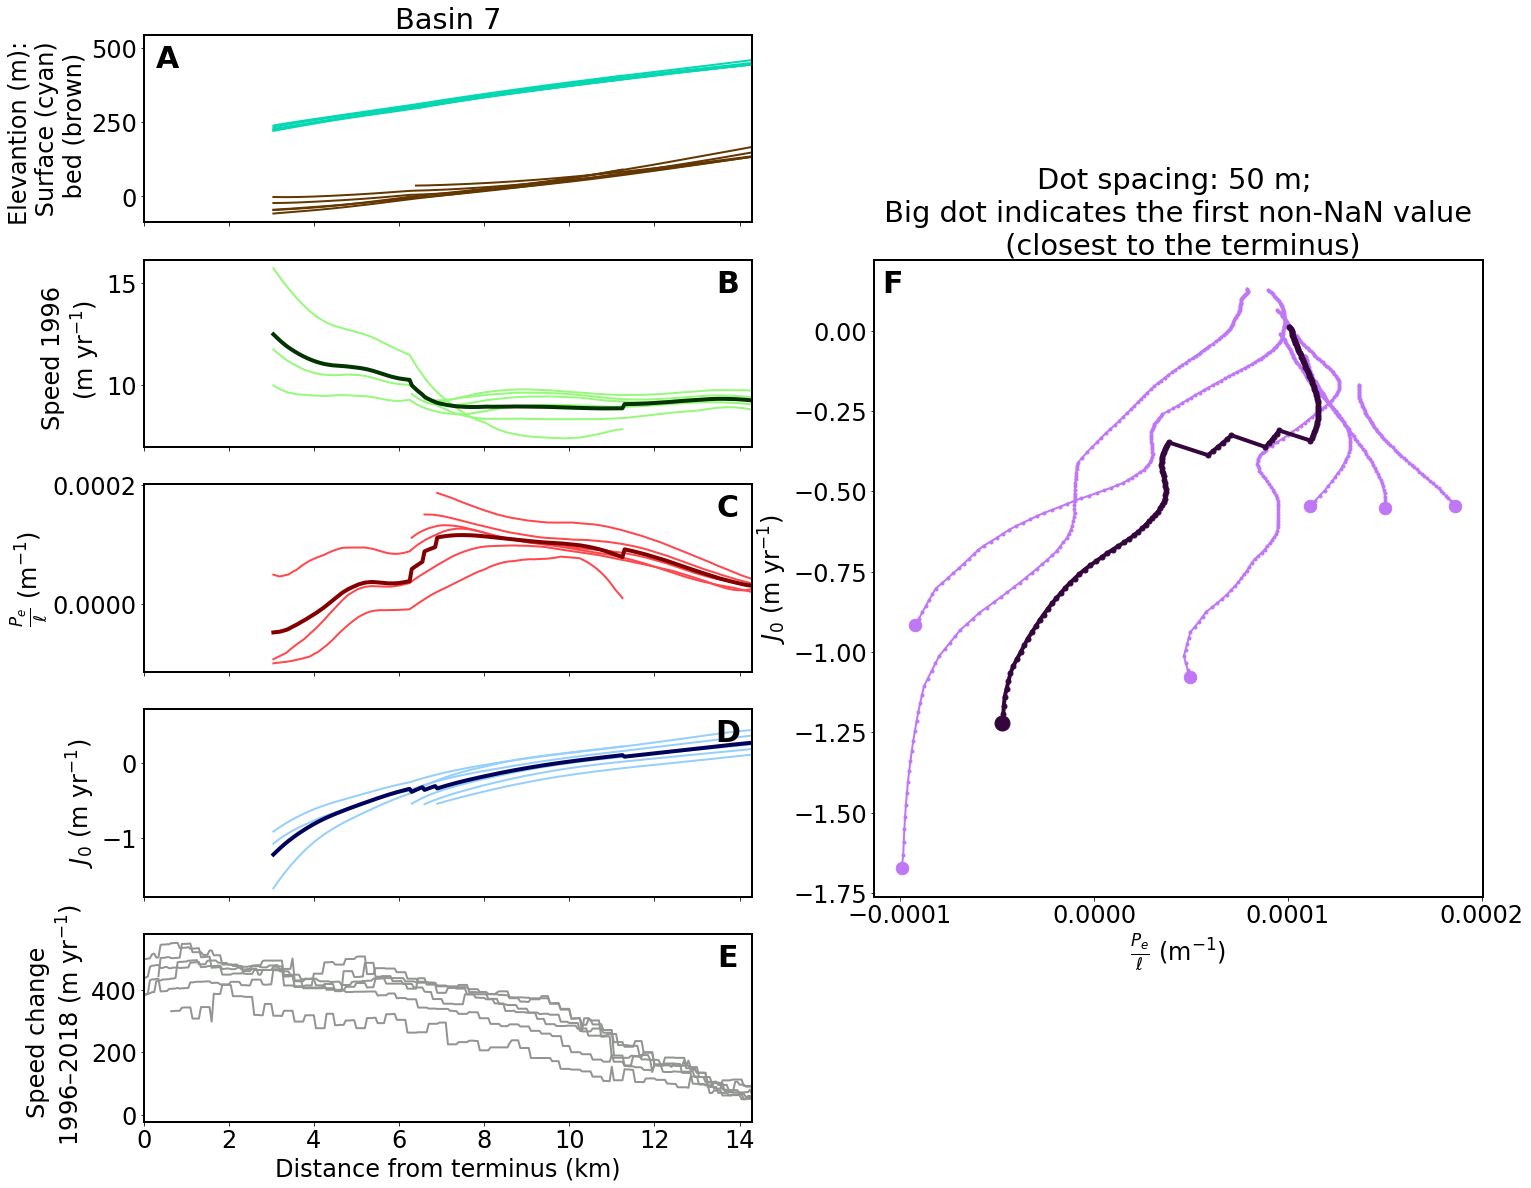

In [19]:
pej0_plot_length = 200   # This determines how many vertices from the terminus should be plotted (200 vertices = 10 km)

matplotlib.rc('font', size=24)
matplotlib.rc('axes', linewidth=2)

basin_no_list = ['7']
# basin_no_list = ['1', '3', '4', '5', '6', '7', '10', '17']

for basin_no in basin_no_list:
    
    # ==== Create axes (5 in the left and a big one in the right)
    fig, ax1 = plt.subplots(5, 2, sharex=True, figsize=(24, 20))
    gs = ax1[1, 1].get_gridspec()
    for ax in ax1[:, 1]:
        ax.remove()
    axbig = fig.add_subplot(gs[1:4, 1])

    # ==== Plot data
    for key in results[basin_no]:
        if key != 'avg':
            ax1[0, 0].plot(results[basin_no][key]['d'], results[basin_no][key]['s'], color='xkcd:aquamarine', linewidth=2)
            ax1[0, 0].plot(results[basin_no][key]['d'], results[basin_no][key]['b'], color='xkcd:brown', linewidth=2)
            ax1[1, 0].plot(results[basin_no][key]['d'], results[basin_no][key]['u'], color='xkcd:light green', linewidth=2)
            ax1[2, 0].plot(results[basin_no][key]['d'], results[basin_no][key]['pe_ignore_dslope'], color='xkcd:light red', linewidth=2)
            ax1[3, 0].plot(results[basin_no][key]['d'], results[basin_no][key]['j0_ignore_dslope'], color='xkcd:light blue', linewidth=2)
            ax1[4, 0].plot(results[basin_no][key]['d'], results[basin_no][key]['udiff'], color='xkcd:gray', linewidth=2)
            axbig.plot(results[basin_no][key]['pe_ignore_dslope'][:pej0_plot_length], results[basin_no][key]['j0_ignore_dslope'][:pej0_plot_length], '.-', color='xkcd:light purple', linewidth=2)
            # plot first non-NaN value (the one closest to the terminus)
            axbig.plot(next(x for x in results[basin_no][key]['pe_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)),
                       next(x for x in results[basin_no][key]['j0_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:light purple', markersize=25)
        else:
            ax1[1, 0].plot(results[basin_no][key]['d'], results[basin_no][key]['u'], color='xkcd:dark green', linewidth=4)
            ax1[2, 0].plot(results[basin_no][key]['d'], results[basin_no][key]['pe_ignore_dslope'], color='xkcd:dark red', linewidth=4)
            ax1[3, 0].plot(results[basin_no][key]['d'], results[basin_no][key]['j0_ignore_dslope'], color='xkcd:dark blue', linewidth=4)
            axbig.plot(results[basin_no][key]['pe_ignore_dslope'][:pej0_plot_length], results[basin_no][key]['j0_ignore_dslope'][:pej0_plot_length], '.-', color='xkcd:dark purple', linewidth=4, markersize=10)
            # plot first non-NaN value (the one closest to the terminus)
            axbig.plot(next(x for x in results[basin_no][key]['pe_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)),
                       next(x for x in results[basin_no][key]['j0_ignore_dslope'][:pej0_plot_length] if not np.isnan(x)), '.', color='xkcd:dark purple', markersize=30)
            
    # ==== Add supplemental text 
    letter_specs = {'fontsize': 30, 'fontweight': 'bold', 'va': 'top', 'ha': 'center'}
    ax1[0, 0].set_title('Basin {}'.format(basin_no))
    ax1[0, 0].set_ylabel('Elevantion (m): \n Surface (cyan) \n bed (brown)')
    ax1[0, 0].text(0.04, 0.95, 'A', transform=ax1[0, 0].transAxes, **letter_specs)
    ax1[1, 0].set_ylabel('Speed 1996 \n (m yr$^{-1}$)')
    ax1[1, 0].text(0.96, 0.95, 'B', transform=ax1[1, 0].transAxes, **letter_specs)
    ax1[2, 0].set_ylabel(r'$\frac{P_e}{\ell}$ (m$^{-1}$)')
    ax1[2, 0].text(0.96, 0.95, 'C', transform=ax1[2, 0].transAxes, **letter_specs)
    ax1[3, 0].set_ylabel(r'$J_0$ (m yr$^{-1}$)')
    ax1[3, 0].text(0.96, 0.95, 'D', transform=ax1[3, 0].transAxes, **letter_specs)
    ax1[4, 0].set_xlabel('Distance from terminus (km)')
    ax1[4, 0].set_ylabel('Speed change \n 1996–2018 (m yr$^{-1}$)')
    ax1[4, 0].set_xlim([0, results[basin_no]['avg']['d'][-1]])
    ax1[4, 0].text(0.96, 0.95, 'E', transform=ax1[4, 0].transAxes, **letter_specs)
    axbig.set_xlabel(r'$\frac{P_e}{\ell}$ (m$^{-1}$)')
    axbig.set_ylabel(r'$J_0$ (m yr$^{-1}$)')
    axbig.set_title('Dot spacing: 50 m; \n Big dot indicates the first non-NaN value \n (closest to the terminus)')
    axbig.text(0.03, 0.985, 'F', transform=axbig.transAxes, **letter_specs)
    axbig.set_xticks([-0.0001, 0, 0.0001, 0.0002])
    
    plt.savefig('../data/results/Austfonna_glacier{}.png'.format(basin_no))

## Visualization

Firstly we use the same color map from **Figure 5** but will eventually stretch it differently.

In [11]:
# Version 1 (original submission)
# colors = np.array([[5,113,176,255],
#                    [171,229,255,255],
#                    [255,240,189,255],
#                    [222,130,38,255],
#                    [202,0,32,255],
#                    [220,22,177,255],
#                    [132,17,177,255]])
# colors = colors / 255
# nodes = (np.array([-500, -300, 100, 500, 1500, 2500, 3500]) + 500) / 4000
# mycmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
# mycmap

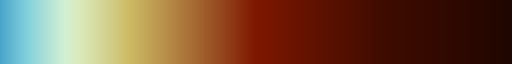

In [12]:
# Version 2 (revised submission, based on the roma colormap https://github.com/GenericMappingTools/gmt/blob/master/share/cpt/roma.cpt)
colors = np.array([[56,156,198,230],
                   [100,198,213,210],
                   [192,234,195,180],
                   [207,229,168,190],
                   [200,180,85,230],
                   [126,23,0,255],
                   [63,12,0,255],
                   [32,6,0,255]])
colors = colors / 255
nodes = (np.array([-500, -300, 0, 100, 500, 1500, 2500, 3500]) + 500) / 4000
mycmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
mycmap

Finally, we can make **Figure 7** by color coding each average glacier flowline using `mycmap` on the profile and the $J_0$-$P_0/\ell$ plots. 

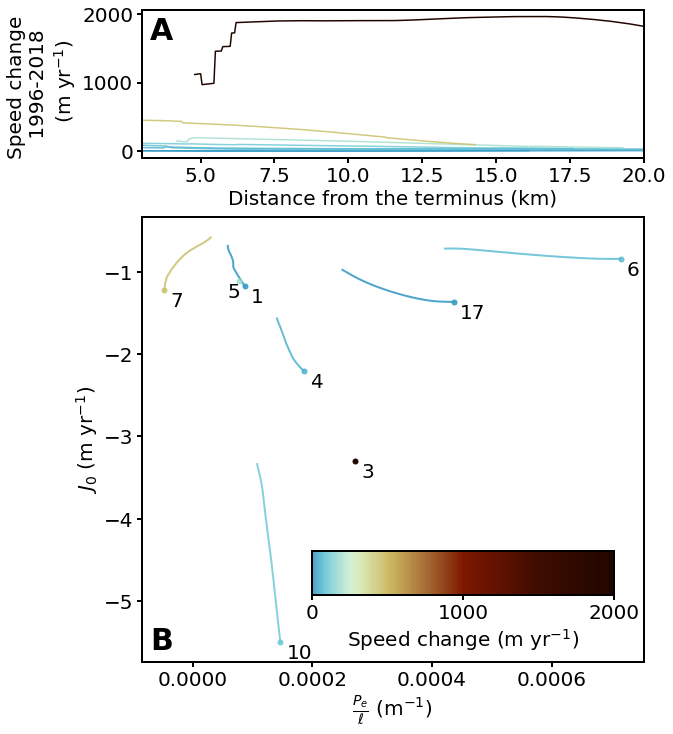

In [29]:
# alias (to keep consistent with Figure 5)
mega_results = results

matplotlib.rc('font', size=20)
matplotlib.rc('axes', linewidth=2)

fig, ax4 = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(9, 12))

for key in mega_results:
    z_max = np.nanmax(mega_results[key]['avg']['udiff_sm'])
    z_min = np.nanmin(mega_results[key]['avg']['udiff_sm'])
    z_value = z_max if abs(z_max) > abs(z_min) else z_min
    #### The color map is stretched between 0 and 2000 m/yr! ####
    z_value_scaled = z_value / 2000
    # z_value_scaled = (z_value + 500) / 4000
    #############################################################
    rgba = mycmap(z_value_scaled)
    # rgba2 = np.array(rgba) / 1.5 
    ax4[0].plot(mega_results[key]['avg']['d'], mega_results[key]['avg']['udiff_sm'], color=rgba)
    ax4[0].set_xlim([3, 20])
    ax4[0].set_xlabel('Distance from the terminus (km)')
    label_top = ax4[0].set_ylabel('Speed change \n 1996-2018 \n (m yr$^{-1}$)')
    ax4[0].tick_params(width=2, length=5)
    ax4[1].plot(mega_results[key]['avg']['pe_ignore_dslope'][:100], mega_results[key]['avg']['j0_ignore_dslope'][:100], color=rgba, linewidth=2)
    # ax4[1].plot(mega_results[key]['avg']['pe_ignore_dslope'][:100], mega_results[key]['avg']['j0_ignore_dslope'][:100], '.', color=rgba, markersize=6)
    ax4[1].plot(next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)),
                next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)), '.', color=rgba, markersize=10)
    ax4[1].set_xlabel(r'$\frac{P_e}{\ell}$ (m$^{-1}$)')
    ax4[1].set_ylabel(r'$J_0$ (m yr$^{-1}$)')
    ax4[1].tick_params(width=2, length=5)
    # Fine tune label location
    if key == '5':
        ax4[1].text(next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)) - 0.00002,
                    next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)) - 0.2, str(key), size=20) # , color=rgba, markersize=15)
    else:
        ax4[1].text(next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)) + 0.00001,
                    next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)) - 0.2, str(key), size=20) # , color=rgba, markersize=15)
    
letter_specs = {'fontsize': 30, 'fontweight': 'bold', 'va': 'top', 'ha': 'center'}
ax4[0].text(0.04, 0.95, 'A', transform=ax4[0].transAxes, **letter_specs)
ax4[1].text(0.04, 0.08, 'B', transform=ax4[1].transAxes, **letter_specs)

cbaxes = ax4[1].inset_axes([0.34, 0.15, 0.6, 0.1])
# norm = matplotlib.colors.Normalize(vmin=-500, vmax=3500)
norm = matplotlib.colors.Normalize(vmin=0, vmax=2000)
# bounds = [-500, 0, 1500, 3500]
bounds = [0, 1000, 2000]

fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=mycmap),
             cax=cbaxes, orientation='horizontal', label='Speed change (m yr$^{-1}$)', ticks=bounds)
cbaxes.tick_params(width=2, length=5)

fig.savefig('../data/results/Fig7.pdf', bbox_extra_artists=(label_top,), bbox_inches='tight')